In [7]:
"""
This file does the finetuning work necessary for the classification of
Yelp reviews that do or do not mention that the place they are for offers
live music.

NOTE: Everything here is highly based on Stephen Hansen's GitHub tutorial
at https://github.com/sekhansen/columbia_lectures_2025/blob/main/code/03_classification_bert.ipynb
and his paper REMOTE WORK ACROSS JOBS, COMPANIES, AND SPACE (Hansen et al.)

Ran on Apple Metal Performance Shaders. Minimum time to run is ~ 20 hours.
There were a few issues in running the model on the entire dataset. In particular,
I constantly monitored the process between chunks and would occasionally have to restart to free up memory.
Overall the process took a few days to fully complete. If running again be sure to pay attention to running progress.
"""
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import random
import os
import gc

In [8]:
# setup
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed at the beginning
set_seed(42)

# setup running on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("Using Apple Metal Performance Shaders (MPS)")

Using device: mps
CUDA available: False
Using Apple Metal Performance Shaders (MPS)


In [9]:
# load data
df = pd.read_csv("./finetuning_reviews.csv", encoding='utf-8')

Prepare data for finetuning

In [10]:
# perform train-test split

n = len(df)
test_size = int(0.1 * n)
indices = np.random.RandomState(95).permutation(n)
train_idxs, test_idxs = indices[test_size:], indices[:test_size]


In [11]:
df_finetune = df.iloc[train_idxs][["text", "live_music"]].copy()
df_finetune['labels'] = df_finetune['live_music']
print(df_finetune.shape)

df_test = df.iloc[test_idxs][["text", "live_music"]].copy()
df_test['labels'] = df_test['live_music']
print(df_test.shape)

(8982, 3)
(997, 3)


In [12]:
df_finetune.head()

,text,live_music,labels
6098,Came here at happy hour on a Friday night; ver...,0,0
4236,"Visiting from Baltimore, MD, we were out walki...",0,0
5195,Being a lover of all foods I have to keep my m...,0,0
6714,I got a Groupon and had been meaning to try th...,0,0
2343,"Impressive first visit to the C House, in Semi...",1,1


Finetune!

In [13]:
# transform data into Dataset class
finetune_dataset = Dataset.from_pandas(df_finetune)
test_dataset = Dataset.from_pandas(df_test)

In [14]:
# we use cased to identify proper nouns
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

# tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=512, padding="max_length", truncation=True)


# batched=True is key for training
tokenized_ft = finetune_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 997/997 [00:00<00:00, 7741.53 examples/s]


In [15]:
model_ft = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-cased",
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
training_args = TrainingArguments(
    output_dir="./",                # path to save model
    learning_rate=5e-5,             # small learning rates
    num_train_epochs=2,             # number of finetuning passes
    per_device_train_batch_size=8,  # batch size per GPU
    per_device_eval_batch_size=8,   # batch size per GPU
    eval_strategy="epoch",          # See metrics during training
    save_strategy="no",             # Don't save checkpoints
    report_to="none",               # Don't report model estimation externally
)

In [17]:
# model performance metrics

metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")
metric_f1 = evaluate.load("f1")
metric_accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric_precision.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric_f1.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [18]:
print(f"Training samples: {len(tokenized_ft)}")
print(f"Batches per epoch: {len(tokenized_ft) / 8}")

Training samples: 8982
Batches per epoch: 1122.75


In [19]:
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ft,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

trainer.train()

/Users/jeff/Projects/spatial_dist_of_music/yelp_data_work/llm_work/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.141100,0.073037,0.975928,0.975928,0.975928,0.975928
2,0.091300,0.056346,0.986961,0.986961,0.986961,0.986961


/Users/jeff/Projects/spatial_dist_of_music/yelp_data_work/llm_work/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=2246, training_loss=0.12352342002644458, metrics={'train_runtime': 1326.1038, 'train_samples_per_second': 13.546, 'train_steps_per_second': 1.694, 'total_flos': 2379644349456384.0, 'train_loss': 0.12352342002644458, 'epoch': 2.0})

evaluate model on test data

In [20]:

# Get predictions
results = trainer.predict(tokenized_test)
predictions = np.argmax(results.predictions, axis=-1)

# Add to dataframe
df_test['prediction'] = predictions

df_test.head()

/Users/jeff/Projects/spatial_dist_of_music/yelp_data_work/llm_work/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


,text,live_music,labels,prediction
2421,This is not the most luxurious or flashy of re...,1,1,1
4810,Day trip in Tucson where we got to hit a few s...,1,1,1
4917,This is one of the coolest looking coffee shop...,0,0,0
7450,Food is great - fresh and prepared perfectly. ...,0,0,0
6788,This place will now be my go to spot. I love t...,0,0,0


In [21]:
# Show mistakes
print("\nMisclassified examples:")
mistakes = df_test[df_test['labels'] != df_test['prediction']]

first_mistake = mistakes.iloc[0]
print(f"Text: {first_mistake['text']}")
print(f"True: {first_mistake['labels']}")
print(f"Predicted: {first_mistake['prediction']}")
# note that this is not actually a mistake!
# There are some minor errors in the labelled dataset.

second_mistake = mistakes.iloc[1]
print(f"Text: {second_mistake['text']}")
print(f"True: {second_mistake['labels']}")
print(f"Predicted: {second_mistake['prediction']}")

print(f"Accuracy: {1-len(mistakes)/len(df_test)}")


Misclassified examples:
Text: Little Tokyo Restaurant chain is one of the best sushi places in New Orleans. The restaurant has been around for 25 years after the Yusuke family moved to New Orleans from Japan. There are several locations around town but our two favorites are the North Carrollton and South Carrollton ones. Both also offer Karaoke rooms. North Carrollton offers a Hibachi room which is also a fun option if you are going in large groups. The South Carrolton location has a younger vibe and has nightly live entertainment with some very talented local musicians. 


The restaurant has fish shipped from Tsukiji market in Tokyo three times a week which leads to authentic dishes and the freshest ingredients. Many rolls are New Orleans inspired with funky names to go with the rolls. After repeated trips to Little Tokyo and trying many of the rolls we have found our favorites: Chocolate city (spicy tuna, snow crab and avocado wrapped with soy paper, seared tuna and crunchy on top w

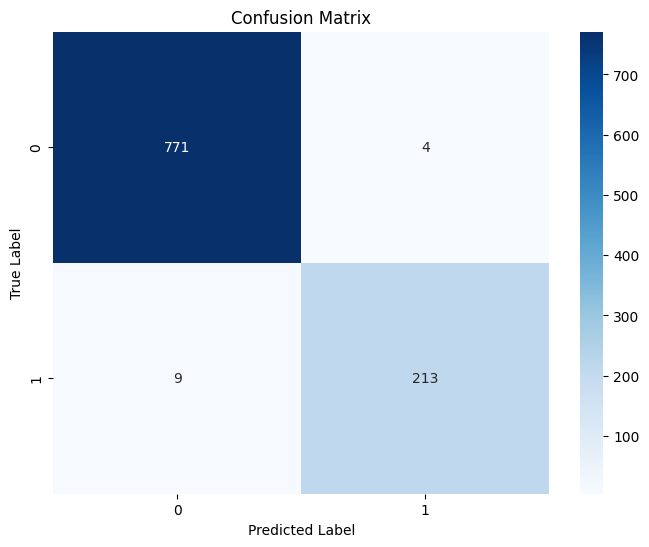

In [23]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test['labels'], df_test['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig('output/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Run on entire dataset

In [2]:
# read in data
all_reviews = pd.read_csv("./all_restaurant_bar_reviews.csv")
all_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,city,year
0,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,tucson,2014
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,philadelphia,2015
2,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,new orleans,2017
3,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,philadelphia,2015
4,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,santa barbara,2016


In [ ]:
# prepare data for classifying
review_df = all_reviews.loc[:, ["review_id", "text"]]

# split into chunks to speed up processing
n = len(review_df)
q = n // 5

c1 = slice(0, q)
c2 = slice(q, 2*q)
c3 = slice(2*q, 3*q)
c4 = slice(3*q, 4*q)
c5 = slice(4*q, n)

In [ ]:
# process chunk 1

# Get chunk 1 data
chunk1_data = review_df.iloc[c1].copy()

chunk1_dataset = Dataset.from_pandas(chunk1_data)
tokenized_chunk1 = chunk1_dataset.map(tokenize_function, batched=True)

results_chunk1 = trainer.predict(tokenized_chunk1)
predictions_chunk1 = np.argmax(results_chunk1.predictions, axis=-1)

# Add predictions to chunk 1
chunk1_data['live_music'] = predictions_chunk1

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Save chunk 1 results
chunk1_data.to_csv('output/chunk1_predictions.csv', index=False)
print(f"Chunk 1 processed: {len(chunk1_data)} reviews saved to output/chunk1_live_music_predictions.csv")

# Clean up memory
del chunk1_data, chunk1_dataset, tokenized_chunk1, results_chunk1, predictions_chunk1
gc.collect()

In [ ]:
# process chunk 2

# Get chunk 2 data
chunk2_data = review_df.iloc[c2].copy()

chunk2_dataset = Dataset.from_pandas(chunk2_data)
tokenized_chunk2 = chunk2_dataset.map(tokenize_function, batched=True)

results_chunk2 = trainer.predict(tokenized_chunk2)
predictions_chunk2 = np.argmax(results_chunk2.predictions, axis=-1)

# Add predictions to chunk 2
chunk2_data['live_music'] = predictions_chunk2

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Save chunk 2 results
chunk2_data.to_csv('output/chunk2_predictions.csv', index=False)
print(f"Chunk 2 processed: {len(chunk2_data)} reviews saved to output/chunk2_live_music_predictions.csv")

# Clean up memory
del chunk2_data, chunk2_dataset, tokenized_chunk2, results_chunk2, predictions_chunk2
gc.collect()

In [ ]:
# process chunk 3

# Get chunk 3 data
chunk3_data = review_df.iloc[c3].copy()

chunk3_dataset = Dataset.from_pandas(chunk3_data)
tokenized_chunk3 = chunk3_dataset.map(tokenize_function, batched=True)

results_chunk3 = trainer.predict(tokenized_chunk3)
predictions_chunk3 = np.argmax(results_chunk3.predictions, axis=-1)

# Add predictions to chunk 3
chunk3_data['live_music'] = predictions_chunk3

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Save chunk 3 results
chunk3_data.to_csv('output/chunk3_predictions.csv', index=False)
print(f"Chunk 3 processed: {len(chunk3_data)} reviews saved to output/chunk3_live_music_predictions.csv")

# Clean up memory
del chunk3_data, chunk3_dataset, tokenized_chunk3, results_chunk3, predictions_chunk3
gc.collect()

In [ ]:
# process chunk 4

# Get chunk 4 data
chunk4_data = review_df.iloc[c4].copy()

chunk4_dataset = Dataset.from_pandas(chunk4_data)
tokenized_chunk4 = chunk4_dataset.map(tokenize_function, batched=True)

results_chunk4 = trainer.predict(tokenized_chunk4)
predictions_chunk4 = np.argmax(results_chunk4.predictions, axis=-1)

# Add predictions to chunk 4
chunk4_data['live_music'] = predictions_chunk4

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Save chunk 4 results
chunk4_data.to_csv('output/chunk4_predictions.csv', index=False)
print(f"Chunk 4 processed: {len(chunk4_data)} reviews saved to output/chunk4_live_music_predictions.csv")

# Clean up memory
del chunk4_data, chunk4_dataset, tokenized_chunk4, results_chunk4, predictions_chunk4
gc.collect()

In [ ]:
# process chunk 5

# Get chunk 5 data
chunk5_data = review_df.iloc[c5].copy()

chunk5_dataset = Dataset.from_pandas(chunk5_data)
tokenized_chunk5 = chunk5_dataset.map(tokenize_function, batched=True)

results_chunk5 = trainer.predict(tokenized_chunk5)
predictions_chunk5 = np.argmax(results_chunk5.predictions, axis=-1)

# Add predictions to chunk 5
chunk5_data['live_music'] = predictions_chunk5

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Save chunk 5 results
chunk5_data.to_csv('output/chunk5_predictions.csv', index=False)
print(f"Chunk 5 processed: {len(chunk5_data)} reviews saved to output/chunk5_live_music_predictions.csv")

# Clean up memory
del chunk5_data, chunk5_dataset, tokenized_chunk5, results_chunk5, predictions_chunk5
gc.collect()

In [ ]:
# Combine all chunks into a single dataset
chunk_files = [
    'output/chunk1_predictions.csv',
    'output/chunk2_predictions.csv', 
    'output/chunk3_predictions.csv',
    'output/chunk4_predictions.csv',
    'output/chunk5_predictions.csv'
]

# Read and combine all chunk files
combined_df = pd.concat([pd.read_csv(file) for file in chunk_files], ignore_index=True)

# Save the combined results
combined_df.to_csv('output/reviews_with_live_music.csv', index=False)
print(f"Combined dataset saved: {len(combined_df)} total reviews in reviews_with_live_music.csv")

# Verify the combination worked correctly
print(f"Shape of combined dataset: {combined_df.shape}")
print(f"Live music distribution: {combined_df['live_music'].value_counts()}")

Combined dataset saved: 3025804 total reviews in reviews_with_live_music.csv
Shape of combined dataset: (3025804, 3)
Live music distribution: live_music
0    2970252
1      55552
Name: count, dtype: int64


In [ ]:
# for double checking restaurants/bars with one review
one_review = pd.read_excel("one_music_reclassified.xlsx")
one_review = one_review[['business_id', 'text']]

one_review_dataset = Dataset.from_pandas(one_review)
tokenized_one_review = one_review_dataset.map(tokenize_function, batched=True)

results_one_review = trainer.predict(tokenized_one_review)
predictions_one_review = np.argmax(results_chunk5.predictions, axis=-1)

one_review['live_music'] = predictions_one_review

one_review.to_csv('./output/one_review_predictions.csv', index=False)


Map: 100%|██████████| 2084/2084 [00:00<00:00, 7056.68 examples/s]


NameError: name 'trainer' is not defined